<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Time_Series/%EA%B8%88%EC%9C%B5%20%ED%8C%8C%EC%9D%B4%EC%8D%AC%20%EC%BF%A1%EB%B6%81/6%EC%9E%A5_%EA%B8%88%EC%9C%B5%EC%97%90%EC%84%9C%EC%9D%98_%EB%AA%AC%ED%85%8C%EC%B9%B4%EB%A5%BC%EB%A1%9C_%EC%8B%9C%EB%AE%AC%EB%A0%88%EC%9D%B4%EC%85%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [63]:
!pip install QuantLib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.8 MB 101 kB/s 


In [64]:
import numpy as np
import pandas as pd
import yfinance as yf
import QuantLib as ql

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
from scipy.stats import norm

# 몬테카를로 시레이션

* 확률적 해석이 가능한 문제의 해결을 위해 반복적된 랜덤 샘플링을 사용하는 계산 알고리즘 분류
* 적분을 정확하게 추정하는 데 사용
* 대개 일정 기간 다양한 시나리오 / 결과가 될 수 있는 다양한 샘플 경로를 생성하는 것
* 이산화 : 그런 다음 기간은 지정된 수의 시간 단계로 분활

# 기하 브라운 운동을 사용한 주가 역학 시뮬레이션

* 가견 변동의 임의성으로 이 시뮬레이션은 확률적 미분 방적식 (SDE)에 의존
* 확률적 프로세스가 SDE를 만족하면 기하 브라운 운동을 따른다고 말함

In [ ]:
RISKY_ASSET = 'MSFT'
START_DATE = '2022-01-01'
END_DATE = '2022-07-31'

In [ ]:
df = yf.download(RISKY_ASSET, start = START_DATE, end = END_DATE, adjusted=True)

[*********************100%***********************]  1 of 1 completed


평균 수익률 : -0.10%


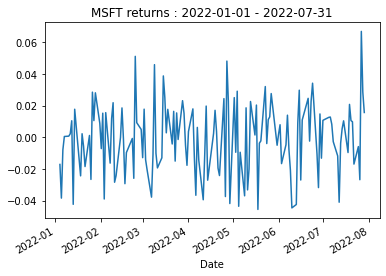

In [6]:
# 일 별 수익률
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

print(f'평균 수익률 : {100 * returns.mean():.2f}%')

returns.plot(title=f'{RISKY_ASSET} returns : {START_DATE} - {END_DATE}')

In [7]:
train = returns['2022-01-01':'2022-06-30']
test = returns['2022-07-01':'2022-07-31']

In [28]:
adj_close[train.index[-1]]

256.2859802246094

In [27]:
T = len(test)
N = len(test)
S_0 = adj_close[train.index[-1]]
N_SIM = 100
mu = train.mean()
sigma = train.std()

In [29]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N):

  dt = T/N

  dw = np.random.normal(scale = np.sqrt(dt), size = (n_sims, N))

  w = np.cumsum(dw, axis=1)

  time_step = np.linspace(dt, T, N)
  time_steps = np.broadcast_to(time_step, (n_sims, N))

  S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps + sigma * w)

  S_t = np.insert(S_t, 0, s_0, axis=1)

  return S_t

In [30]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

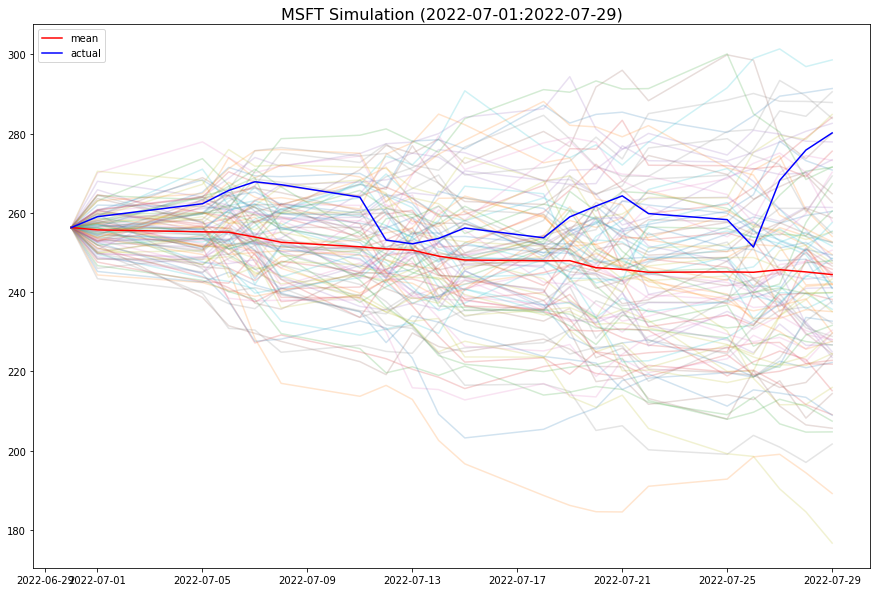

In [45]:
# prepare objects for plotting 

last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False, figsize=(15,10))

line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

# 시뮬레이션을 사용한 유럽 옵션 가격 결정

옵션을 평가하는 기법

* 분석 공식을 사용
* 이항 트리 기법
* 유한 차분법
* 몬테카를로 시뮬레이션

In [51]:
S_0 = 100 # 최초 가격
K = 100 # 스트라이크 가격 : 즉 만기 시 매수/매도 할 수 있는 가격
r = 0.05 # 연간 무위험 금리
sigma = 0.50 # 기로 주식 변동성
T = 1 # 만기 때까지의 시간
N = 252 # 시뮬레이션의 시간 증분 수
dt = T / N # 시간 단계
N_SIMS = 10 ** 6 # 시뮬레이션된 단순 경로 수
discount_factor = np.exp(-r * T) # 할인 요인

In [52]:
def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if type == 'call':
        val = (S_0 * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))

    elif type == 'put':
        val = (K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S_0 * norm.cdf(-d1, 0, 1))
        
    else:
        raise ValueError('Wrong input for type!')
        
    return val

In [53]:
# 콜 옵션 평가
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='call')

21.79260421286685

In [54]:
# 주식 경로를 시뮬레이션
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, T=T, N=N)

In [55]:
# 옵션 프리미엄 계산
premium = discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
premium

21.7634569281774

# 최소 자승 몬테카를로를 사용해 미국 옵션 가격 결정

In [56]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1 # 1 year
N = 50 
dt = T / N 
N_SIMS = 10 ** 5 
discount_factor = np.exp(-r * dt)
OPTION_TYPE = 'put'
POLY_DEGREE = 5 

In [57]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, T=T, N=N)

In [58]:
# 수익 행렬 계산
payoff_matrix = np.maximum(K - gbm_sims, np.zeros_like(gbm_sims))

In [59]:
# 가치 행렬 정의 / 마지막 열을 채움
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1]

In [60]:
# 주어진 시간에 대한 가치 벡터와 유지 가치를 반복 계산
for t in range(N - 1, 0 , -1):

    regression = np.polyfit(gbm_sims[:, t], value_matrix[:, t + 1] * discount_factor, POLY_DEGREE)
    
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],
        value_matrix[:, t + 1] * discount_factor
    )

In [61]:
# 옵션 프리미엄 계산
option_premium = np.mean(value_matrix[:, 1] * discount_factor)
print(f'The premium on the specified American {OPTION_TYPE} option is {option_premium:.3f}')

The premium on the specified American put option is 4.449


In [62]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='put')

3.84430779159684

# Quantlib를 사용한 미국 옵션 가격 결정

In [65]:
calendar = ql.UnitedStates()
day_counter = ql.ActualActual()

In [66]:
# 옵션의 평가일과 만기일 설정
valuation_date = ql.Date(1, 1, 2020)
expiry_date =  ql.Date(1, 1, 2021)
ql.Settings.instance().evaluationDate = valuation_date

In [67]:
# 옵션 형식과 행사 유형, 수익 정의
if OPTION_TYPE == 'call':

    option_type_ql = ql.Option.Call

elif OPTION_TYPE == 'put':
  
    option_type_ql = ql.Option.Put
        
exercise = ql.AmericanExercise(valuation_date, expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

In [68]:
# 시장 관련 데이터
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

In [69]:
# 시장 관련 곡선 설정
underlying = ql.QuoteHandle(u)

volatility = ql.BlackConstantVol(0,
                                 ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)

risk_free_rate = ql.FlatForward(0,
                                ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

In [70]:
# 시장 관련 데이터를 BS프로세스에 플러그
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

In [72]:
# 미국 옵션에 대한 몬테카를로 엔진을 인스턴스화
engine = ql.MCAmericanEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                             polynomOrder=POLY_DEGREE, 
                             seedCalibration=42, 
                             requiredSamples=N_SIMS)

In [73]:
# option 객체를 인스턴스화하고 가격 책정 엔진을 설정
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

In [74]:
# 옵션 프리미엄 계산
option_premium_ql = option.NPV()
print(f'The value of the American {OPTION_TYPE} option is: {option_premium_ql:.3f}')


The value of the American put option is: 4.453


# 모네카를로를 사용해 VAR 추정

Value - at - risk

* 정상적인 시장 조건하에서 특정 기간 동안 최악의 예상 손실을 의미

VAR 계산 방법

* 모수적 기법
* 과거 시뮬레이션 기법
* 몬테카를로 시뮬레이션

In [85]:
RISKY_ASSETS = ['GOOG', 'META']
SHARES = [5, 5]
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'
T = 1
N_SIMS = 10 ** 5

In [86]:
df = yf.download(RISKY_ASSETS,
                 start=START_DATE, 
                 end=END_DATE,
                 adjusted=True)

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  2 of 2 completed
Downloaded 251 rows of data.


In [87]:
df.head()

Adj Close                  Close                   High  \
                 GOOG        META       GOOG        META       GOOG   
Date                                                                  
2021-01-04  86.412003  268.940002  86.412003  268.940002  88.032501   
2021-01-05  87.045998  270.970001  87.045998  270.970001  87.383499   
2021-01-06  86.764503  263.309998  86.764503  263.309998  87.400002   
2021-01-07  89.362503  268.739990  89.362503  268.739990  89.419998   
2021-01-08  90.360497  267.570007  90.360497  267.570007  90.491997   

                              Low                   Open              \
                  META       GOOG        META       GOOG        META   
Date                                                                   
2021-01-04  275.000000  85.392502  265.200012  87.876999  274.779999   
2021-01-05  272.399994  85.900749  268.209991  86.250000  268.290009   
2021-01-06  267.750000  84.949997  260.010010  85.131500  262.000000   
2021-01-07  271.609985  86.852501  264.779999  87.002998  265.899994   
2021-01-08  268.950012  88.676750  263.179993  89.399002  268.309998   

              Volume            
                GOOG      META  
Date                            
2021-01-04  38038000  15106100  
2021-01-05  22906000   9871600  
2021-01-06  52042000  24354100  
2021-01-07  45300000  15789800  
2021-01-08  41012000  18528300

Correlation between returns: 0.57


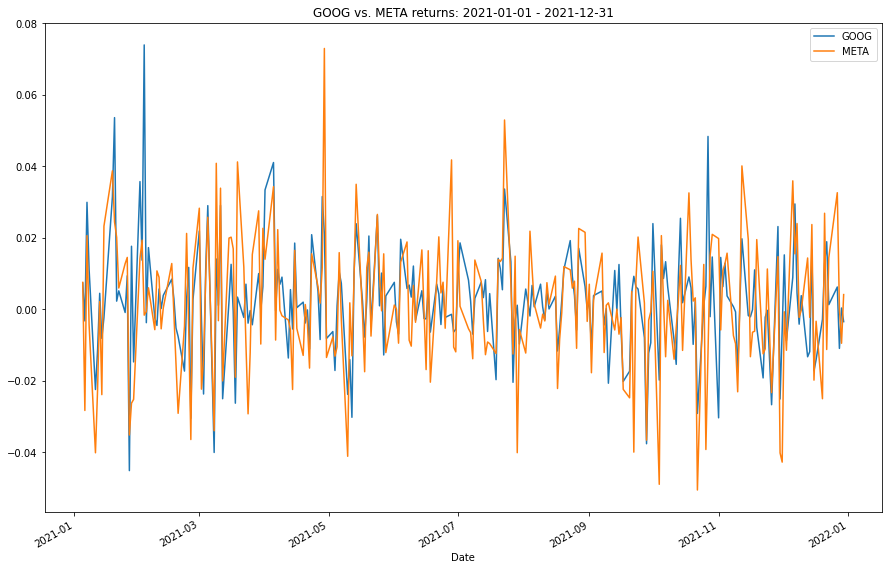

In [90]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
plot_title = f'{" vs. ".join(RISKY_ASSETS)} returns: {START_DATE} - {END_DATE}'
returns.plot(title=plot_title, figsize=(15, 10))

print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

In [91]:
# 공분산 행렬 계산
cov_mat = returns.cov()
cov_mat

,GOOG,META
GOOG,0.000223,0.000158
META,0.000158,0.000346


In [92]:
# 공분산 행렬의 촐레스키 분해 수행
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.01494687, 0.        ],
       [0.01056844, 0.01531328]])

In [93]:
# 표준 정규 분포로부터 상관된 랜덤 수를 추출
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

In [94]:
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :]
P_0 = np.sum(SHARES * S_0)

In [95]:
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv)

In [96]:
# 최종 포트폴리오 가치와 포트폴리오 수익률 계산
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

In [98]:
# 선택된 신뢰 수준의 VAR 계산
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: -0.68$
1-day VaR with 99.9% confidence: -1.08$
1-day VaR with 99.0% confidence: -1.61$


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


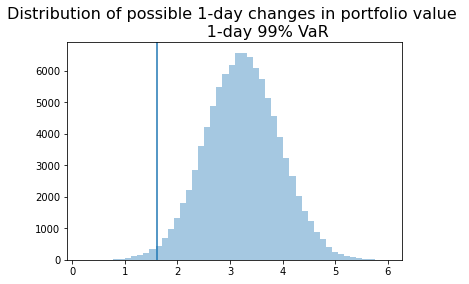

In [99]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR''', fontsize=16)
ax.axvline(var[2], 0, 10000)